<div style="display: flex; background-color: RGB(255,114,0); padding: 30px;" >

# MNIST 
</div>

Dans ce projet, nous utiliserons l'ensemble de données **MNIST**, qui est un ensemble de 70 000 petites images de chiffres écrits à la main par des lycéens et des employés du Bureau américain du recensement.        
Chaque image est étiquetée avec le chiffre qu'elle représente.    
Cet ensemble a été tellement étudié qu'il est souvent appelé le "hello world" de Apprentissage automatique : chaque fois que les gens proposent une nouvelle classification algorithme, ils sont curieux de voir comment il fonctionnera sur **MNIST**, et toute personne qui apprend l'apprentissage automatique s'attaque à cet ensemble de données tôt ou tard.   
**Scikit-Learn** fournit de nombreuses fonctions d'assistance pour télécharger des ensembles de données populaires.     
Le MNIST en fait partie. https://www.kaggle.com/c/digit-recognizer     
https://fr.wikipedia.org/wiki/Base_de_donn%C3%A9es_MNIST     


Avant de commancer le projet essayez de voir les cours et faire les travaux pratiques SVM.
http://cedric.cnam.fr/vertigo/cours/ml2/      

C'est un projet de classification, alors utiliser par exemple les modèles de Machine Learning de la librairie **scikit-learn** suivant: https://scikit-learn.org/stable/supervised_learning.html    

* LogisticRegression
* KNN
* SVC :
  * https://scikit-learn.org/stable/modules/svm.html#classification
  * http://cedric.cnam.fr/vertigo/cours/ml2/tpSVMLineaires.html
  * http://cedric.cnam.fr/vertigo/cours/ml2/tpMethodesNoyaux.html#machines-a-vecteurs-de-support-svm


Essayer de définir et comprendre les mots clefs de chaque algorithme

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mnist_function import *
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder
import time
from collections import defaultdict

<div style="display: flex; background-color: Blue; padding: 15px;" >

## 1.Chargement des données
</div>

In [2]:
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

- La clé **DESCR** décrivant le jeu de données

- La clé **data** contenant un tableau avec une ligne par instance et une colonne par caractéristique

- La clé **target** contenant un tableau avec les étiquettes

Voir le site officiel : http://yann.lecun.com/exdb/mnist/

Cf. 1er note book pour l'exploration

<div style="display: flex; background-color: Green; padding: 7px;" >

### 2.1. X et Y
</div>

In [3]:
X, y = mnist["data"], mnist["target"]

In [4]:
y = y.astype(np.uint8)

Mais attendez! Vous devez toujours créer une campagne de test et la mettre de côté avant d'inspecter les données de près. Le jeu de données **MNIST** est en fait déjà divisé en un ensemble d'apprentissage (les 60 000 premières images) et un ensemble de tests (les 10 000 dernières images):

In [5]:
X_train, X_test, Y_train, Y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [6]:
X_train.shape

(60000, 784)

In [7]:
Y_train

0        5
1        0
2        4
3        1
4        9
        ..
59995    8
59996    3
59997    5
59998    6
59999    8
Name: class, Length: 60000, dtype: uint8

In [8]:
Y_test

60000    7
60001    2
60002    1
60003    0
60004    4
        ..
69995    2
69996    3
69997    4
69998    5
69999    6
Name: class, Length: 10000, dtype: uint8

<div style="display: flex; background-color: Green; padding: 7px;" >

### 2.5. Visualisation
</div>

<div style="display: flex; background-color: indigo;" >

#### 2.5.1. Des images / Chiffres
</div>

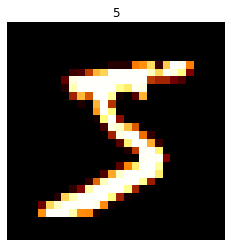

In [9]:
show_digit(X.values[0], y[0])
plt.show()

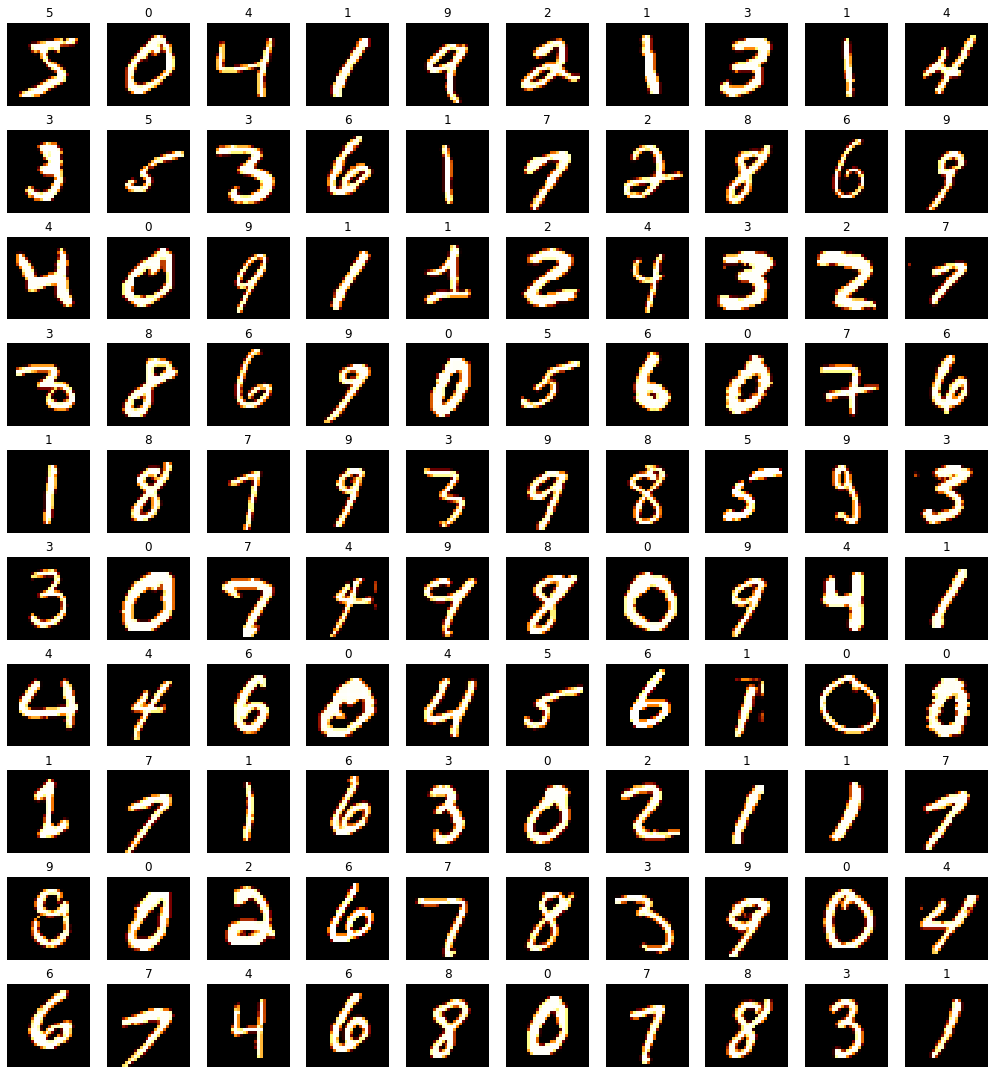

In [33]:
draw_digits(X, y, 100)

In [13]:
def get_model_list(random_state=0, n_neighbors=3, verbose=0):
    model_list = {"Logistic":LogisticRegression(random_state=random_state, verbose=verbose),
                  "Logistic OVR":LogisticRegression(random_state=random_state, multi_class='ovr', verbose=verbose),
                  "SVC OVO":svm.SVC(random_state=random_state, verbose=verbose),
                  "KNN":KNeighborsClassifier(n_neighbors=n_neighbors),
                  "LinearSVC OVR":LinearSVC(random_state=random_state)}
    return model_list

<div style="display: flex; background-color: Blue; padding: 15px;" >

## Problème 2 : Classification Multiclass
</div>

Alors que les classificateurs binaires distinguent deux classes, les multiclasses
les classificateurs (également appelés classificateurs multinomiaux) peuvent faire la distinction entre plus de deux classes.
Certains algorithmes (tels que les classificateurs `SGD`, les classificateurs `Random Forest` et
classificateurs `Bayes naïfs`) sont capables de gérer plusieurs classes de manière native.    

Autres (tels que les classificateurs `Logistic Regression` ou `Support Vector Machine`)
sont des classificateurs strictement binaires.     
https://scikit-learn.org/stable/modules/classes.html#module-sklearn.svm     
Cependant, il existe diverses stratégies que vous peut utiliser pour effectuer une classification multiclasse avec plusieurs classificateurs binaires.    
* `OvR` : Une façon de créer un système qui peut classer les images numériques en 10 classes
(de 0 à 9) consiste à former 10 classificateurs binaires, un pour chaque chiffre (un détecteur de 0,
un 1-détecteur, un 2-détecteur, etc.). Ensuite, lorsque vous voulez classer un image, vous obtenez le score de décision de chaque classificateur pour cette image et vous sélectionnez la classe dont le classificateur génère le score le plus élevé. C'est appelé la stratégie un contre les autres (OvR) (également appelée un contre tous).
* `OvO` : Une autre stratégie consiste à former un classificateur binaire pour chaque paire de chiffres : un à distinguer les 0 et les 1, un autre pour distinguer les 0 et les 2, un autre pour les 1 et 2, et ainsi de suite. C'est ce qu'on appelle la stratégie un contre un (OvO)
  * ovo plus precis, mais trop de calcule si on a beaucoup de class dans le target   

Composition :

* `SVM` = `SVC` et `SVR` et `LinearSVC`
   * `SVC` : classification par défaut `OVO` => dataset taille modérée et Attention au nb de classes : OVO `(N(N-1))/2` ex : `(10*(9)/2)`
   * `LinearSVC` : `OVR` => : OVR `N modèles` ex : `(10 modèles)`
   * ~~~~~~~~~~~~~~~~~~~~
   * `SVR` : régression
   * `LinearSVR` : régression


Scikit-Learn détecte quand vous essayez d'utiliser un algorithme de classification binaire pour une tâche de classification multiclasse, et il exécute automatiquement OvR ou OvO, en fonction de l'algorithme.

<div style="display: flex; background-color: Green; padding: 7px;" >

### 4.1. Test pour tous les chiffres ensemble
</div>

Test sans paramétrage particulier

In [11]:
random_state=0
verbose=0

In [14]:
modeldic_all, scores = fit_and_test_models(get_model_list(verbose=verbose), X_train, Y_train, X_test, Y_test, y_column_name=None, scores=None, verbose=verbose, metrics=2)
modeldic_full = modeldic_all

score_all_class_df = pd.DataFrame(scores).set_index("Modeli")
score_all_class_df.round(decimals=3)
score_all_class_df

,Class,Model,R2,fit time,fit seconde,metrics time,metrics seconde,predict time,predict seconde,MAE,...,Brier loss,Log loss,F1 micro,F1 macro,F1 weighted,Recall micro,Recall macro,Recall weighted,Roc auc ovo,Roc auc ovr
Modeli,,,,,,,,,,,,,,,,,,,,,
Logistic,,Logistic,0.9255,00:00:31,31.435545,00:00:00,0.133862,00:00:00,0.047684,9.7528,...,NaN,NaN,0.9255,0.924435,0.925383,0.9255,0.924421,0.9255,NaN,NaN
Logistic OVR,,Logistic OVR,0.9178,00:01:18,78.223257,00:00:00,0.107753,00:00:00,0.036828,10.4762,...,NaN,NaN,0.9178,0.916627,0.917671,0.9178,0.916545,0.9178,NaN,NaN
SVC OVO,,SVC OVO,0.9792,00:06:10,370.411717,00:02:34,154.793102,00:02:34,154.761578,2.9810,...,NaN,NaN,0.9792,0.979130,0.979186,0.9792,0.979092,0.9792,NaN,NaN
KNN,,KNN,0.9705,00:00:24,24.344282,00:00:45,45.083683,00:00:22,22.762729,4.8210,...,NaN,NaN,0.9705,0.970375,0.970452,0.9705,0.970114,0.9705,NaN,NaN
LinearSVC OVR,,LinearSVC OVR,0.8742,00:04:48,288.512176,00:00:00,0.074934,00:00:00,0.045680,12.4434,...,NaN,NaN,0.8742,0.873509,0.875089,0.8742,0.871794,0.8742,NaN,NaN


In [15]:
modeldic_full.keys()

dict_keys(['Logistic', 'Logistic OVR', 'SVC OVO', 'KNN', 'LinearSVC OVR'])

A ce stade les scores sont déjà très bons.

<div style="display: flex; background-color: Green; padding: 7px;" >

### 4.2. Classifier Multiclass
</div>

<div style="display: flex; background-color: indigo;" >

#### 4.2.1. OneVsRestClassifier
</div>

One-vs-the-rest (OvR) multiclass strategy.

In [16]:
model_oo_list = {}

In [17]:
from sklearn.multiclass import OneVsRestClassifier
ovr= OneVsRestClassifier(svm.SVC(random_state=random_state, verbose=verbose))
model_oo_list["OVRC-SVC"] = ovr

<div style="display: flex; background-color: indigo;" >

#### 4.2.2. OneVsOneClassifier
</div>

One-vs-one multiclass strategy.

In [18]:
from sklearn.multiclass import OneVsOneClassifier
ovo= OneVsOneClassifier(svm.SVC(random_state=random_state, verbose=verbose))
model_oo_list["OVOC-SVC"] = ovo

<div style="display: flex; background-color: indigo;" >

#### 4.2.3. OutputCodeClassifier
</div>

(Error-Correcting) Output-Code multiclass strategy.

In [19]:
from sklearn.multiclass import OutputCodeClassifier
occ= OutputCodeClassifier(svm.SVC(random_state=random_state, verbose=verbose))
model_oo_list["OCC-SVC"] = occ

<div style="display: flex; background-color: indigo;" >

#### 4.2.4. FIT
</div>

In [20]:
scores_save = scores

In [22]:
modeldic_all, scores2 = fit_and_test_models(model_oo_list, X_train, Y_train, X_test, Y_test, y_column_name=None, scores=scores, verbose=verbose, metrics=2)
modeldic_full.update(modeldic_all)

score_all_ooo_df = pd.DataFrame(scores2).set_index("Modeli")
score_all_ooo_df

,Class,Model,R2,fit time,fit seconde,metrics time,metrics seconde,predict time,predict seconde,MAE,...,Brier loss,Log loss,F1 micro,F1 macro,F1 weighted,Recall micro,Recall macro,Recall weighted,Roc auc ovo,Roc auc ovr
Modeli,,,,,,,,,,,,,,,,,,,,,
Logistic,,Logistic,0.9255,00:00:31,31.435545,00:00:00,0.133862,00:00:00,0.047684,9.7528,...,NaN,NaN,0.9255,0.924435,0.925383,0.9255,0.924421,0.9255,NaN,NaN
Logistic OVR,,Logistic OVR,0.9178,00:01:18,78.223257,00:00:00,0.107753,00:00:00,0.036828,10.4762,...,NaN,NaN,0.9178,0.916627,0.917671,0.9178,0.916545,0.9178,NaN,NaN
SVC OVO,,SVC OVO,0.9792,00:06:10,370.411717,00:02:34,154.793102,00:02:34,154.761578,2.9810,...,NaN,NaN,0.9792,0.979130,0.979186,0.9792,0.979092,0.9792,NaN,NaN
KNN,,KNN,0.9705,00:00:24,24.344282,00:00:45,45.083683,00:00:22,22.762729,4.8210,...,NaN,NaN,0.9705,0.970375,0.970452,0.9705,0.970114,0.9705,NaN,NaN
LinearSVC OVR,,LinearSVC OVR,0.8742,00:04:48,288.512176,00:00:00,0.074934,00:00:00,0.045680,12.4434,...,NaN,NaN,0.8742,0.873509,0.875089,0.8742,0.871794,0.8742,NaN,NaN
OVRC-SVC,,OVRC-SVC,0.9800,00:31:17,1877.172744,00:02:47,167.930872,00:02:47,167.893301,2.7312,...,NaN,NaN,0.9800,0.979985,0.979989,0.9800,0.980000,0.9800,NaN,NaN
OVOC-SVC,,OVOC-SVC,0.9796,00:08:19,499.660273,00:04:54,294.060788,00:04:54,294.038731,2.7320,...,NaN,NaN,0.9796,0.979496,0.979593,0.9796,0.979470,0.9796,NaN,NaN
OCC-SVC,,OCC-SVC,0.9766,01:43:00,6180.895098,00:10:32,632.845633,00:10:32,632.813596,3.2890,...,NaN,NaN,0.9766,0.976503,0.976591,0.9766,0.976520,0.9766,NaN,NaN


<div style="display: flex; background-color: Green; padding: 7px;" >

### 4.X. Evaluation / Comparaison
</div

<div style="display: flex; background-color: indigo;" >

#### 4.2.2. R2 et temps d'exécution
</div>

In [23]:
score_all_ooo_df["Total use seconde"] = score_all_ooo_df["fit seconde"] + score_all_ooo_df["predict seconde"]

In [24]:
score_all_ooo_df["Total use time"] = score_all_ooo_df["Total use seconde"].apply(lambda x: time.strftime("%H:%M:%S", time.gmtime(x)))

In [25]:
score_all_ooo_df[["R2", "Total use time", "fit time", "predict time", "metrics time", "Total use seconde", "fit seconde", "predict seconde", "metrics seconde"]].sort_values(by=["R2", "Total use time"], ascending=False)

,R2,Total use time,fit time,predict time,metrics time,Total use seconde,fit seconde,predict seconde,metrics seconde
Modeli,,,,,,,,,
OVRC-SVC,0.9800,00:34:05,00:31:17,00:02:47,00:02:47,2045.066045,1877.172744,167.893301,167.930872
OVOC-SVC,0.9796,00:13:13,00:08:19,00:04:54,00:04:54,793.699004,499.660273,294.038731,294.060788
SVC OVO,0.9792,00:08:45,00:06:10,00:02:34,00:02:34,525.173295,370.411717,154.761578,154.793102
OCC-SVC,0.9766,01:53:33,01:43:00,00:10:32,00:10:32,6813.708694,6180.895098,632.813596,632.845633
KNN,0.9705,00:00:47,00:00:24,00:00:22,00:00:45,47.107011,24.344282,22.762729,45.083683
Logistic,0.9255,00:00:31,00:00:31,00:00:00,00:00:00,31.483230,31.435545,0.047684,0.133862
Logistic OVR,0.9178,00:01:18,00:01:18,00:00:00,00:00:00,78.260085,78.223257,0.036828,0.107753
LinearSVC OVR,0.8742,00:04:48,00:04:48,00:00:00,00:00:00,288.557856,288.512176,0.045680,0.074934


<div style="display: flex; background-color: indigo;" >

#### 4.2.4. Errors
</div>

In [29]:
score_all_ooo_df[["R2","MAE", "MSE", "RMSE", "Mediane AE", "F1 micro", "F1 macro", "F1 weighted", "Recall micro", "Recall macro", "Recall weighted"]]

,R2,MAE,MSE,RMSE,Mediane AE,F1 micro,F1 macro,F1 weighted,Recall micro,Recall macro,Recall weighted
Modeli,,,,,,,,,,,
Logistic,0.9255,9.7528,1.2852,1.133667,0.0,0.9255,0.924435,0.925383,0.9255,0.924421,0.9255
Logistic OVR,0.9178,10.4762,1.4546,1.206068,0.0,0.9178,0.916627,0.917671,0.9178,0.916545,0.9178
SVC OVO,0.9792,2.9810,0.4148,0.644050,0.0,0.9792,0.979130,0.979186,0.9792,0.979092,0.9792
KNN,0.9705,4.8210,0.5792,0.761052,0.0,0.9705,0.970375,0.970452,0.9705,0.970114,0.9705
LinearSVC OVR,0.8742,12.4434,2.1162,1.454716,0.0,0.8742,0.873509,0.875089,0.8742,0.871794,0.8742
OVRC-SVC,0.9800,2.7312,0.4244,0.651460,0.0,0.9800,0.979985,0.979989,0.9800,0.980000,0.9800
OVOC-SVC,0.9796,2.7320,0.4060,0.637181,0.0,0.9796,0.979496,0.979593,0.9796,0.979470,0.9796
OCC-SVC,0.9766,3.2890,0.4642,0.681322,0.0,0.9766,0.976503,0.976591,0.9766,0.976520,0.9766


<div style="display: flex; background-color: Green; padding: 7px;" >

### 3.2. GridSearchCV
</div>